In [1]:
import numpy as np
import timeit
import tvm
from tvm import te
import utils 

target = 'llvm -mcpu=tigerlake'

In [2]:
import os
os.environ['KMP_AFFINITY']='granularity=fine,noduplicates,compact,1,0'

In [3]:
def conv_gflop(oc, ic, n, k, p, s):
    """Compute the #floating point operations in a convolution.

    The arguments are output channels oc, input channels ic, input size n,
    kernel size k, padding p and stride s.
    """
    on = utils.conv_out_size(n, k, p, s)
    return 2 * oc * ic * on * on * k * k / 1e9

In [4]:
def conv_timer_mxnet(c, n, k, ctx):
    """Benchmark convolution in MXNet

    c : input, output channels
    n : input width and height
    k : kernel width and height
    """
    timer = timeit.Timer(
        setup='import utils\n'
        'import mxnet as mx\n'
        'c, n, k, p, s = %d, %d, %d, %d, 1\n'
        'data, weight, bias, out = utils.get_conv_data_mxnet(\n'
        '    c, c, n, k, p, s, "%s")'%(c, n, k, (k-1)//2, ctx),
        stmt='utils.conv_mxnet(data, weight, bias, out, k, p, s);'
        'out.wait_to_read()')
    return timer.timeit

In [5]:
def bench_workload(workload):
    """Benchmark a workload
    workload: a method that accept a num_repeat argument
    and return its total execution time
    """
    workload(1)  # warmup
    time = workload(1)  # the time to run once
    if time > 1: return time
    # The number of repeats to measure at least 1 second
    num_repeats = max(int(1.0 / time), 5)
    return workload(num_repeats) / num_repeats

In [6]:
def bench_conv_mxnet(sizes, ctx='cpu'):
    """Return the GFLOPS of MXNet convolution"""
    return [conv_gflop(c, c, n, k, (k-1)//2, 1) /
            bench_workload(conv_timer_mxnet(c, n, k, ctx))
                for c, n, k in sizes]

In [7]:
channels = 2**np.arange(4, 9)
# a list of (c, n, k)
sizes = [(int(c), 64, 3) for c in channels]
mxnet_gflops = bench_conv_mxnet(sizes)

In [8]:
def bench_conv_tvm(func, sizes, target):
    def workload(nrepeats):
        dev = tvm.device(target)
        timer = mod.time_evaluator(mod.entry_name, dev=dev, number=nrepeats)
        return timer(x, k, y).mean * nrepeats
    gflops, times = [], []
    for (c, n, k) in sizes:
        args = c, c, n, k, (k-1)//2, 1 # oc, ic, n, k, p, s
        s, (X, K, Y) = func(*args)
        mod = tvm.build(s, [X, K, Y], target)
        x, k, y = utils.get_conv_data(
            *args, lambda x: tvm.nd.array(x))
        times.append(bench_workload(workload))
        gflops.append(conv_gflop(*args))
    return np.array(gflops) / np.array(times)

In [9]:
th, tw = 8, 8  # Tile sizes for height and weight

def cached_block(oc, ic, n, k, p, s):
    X, K, Y, PaddedX = utils.conv(oc, ic, n, n, k, k, p, p, s, s)
    s = te.create_schedule(Y.op)
    CachedY = s.cache_write(Y, 'local')
    # Compute the output block for every output channel in parallel
    oc, h, w = Y.op.axis
    ho, wo, hi, wi = s[Y].tile(h, w, th, tw)
    ochw = s[Y].fuse(oc, ho, wo)
    s[Y].parallel(ochw)
    # Cache the output block, and move the inner height and width axes
    # to innermost, so we can vectorize and unroll them
    s[CachedY].compute_at(s[Y], ochw)
    _,  ch, cw = CachedY.op.axis
    ric, rkh, rkw = CachedY.op.reduce_axis
    s[CachedY].reorder(ric, rkh, rkw, ch, cw)
    s[CachedY].vectorize(cw)
    s[CachedY].unroll(ch)
    # Schedule the padding by adding thread-level parallelism
    if PaddedX != X:
        s[PaddedX].parallel(PaddedX.op.axis[0])
    return s, (X, K, Y)

s, args = cached_block(32, 32, 64, 3, 1, 1)
tvm.lower(s, args, simple_mode=True)

#[version = "0.0.5"]
@main = primfn(X_1: handle, K_1: handle, Y_1: handle) -> ()
  attr = {"from_legacy_te_schedule": True, "global_symbol": "main", "tir.noalias": True}
  buffers = {X: Buffer(X_2: Pointer(float32), float32, [131072], []),
             K: Buffer(K_2: Pointer(float32), float32, [9216], []),
             Y: Buffer(Y_2: Pointer(float32), float32, [131072], [])}
  buffer_map = {X_1: X, K_1: K, Y_1: Y}
  preflattened_buffer_map = {X_1: X_3: Buffer(X_2, float32, [32, 64, 64], []), K_1: K_3: Buffer(K_2, float32, [32, 32, 3, 3], []), Y_1: Y_3: Buffer(Y_2, float32, [32, 64, 64], [])} {
  allocate(PaddedX: Pointer(global float32), float32, [139392]), storage_scope = global {
    for (i0: int32, 0, 32) "parallel" {
      for (i1: int32, 0, 66) {
        for (i2: int32, 0, 66) {
          PaddedX_1: Buffer(PaddedX, float32, [139392], [])[(((i0*4356) + (i1*66)) + i2)] = @tir.if_then_else(((((i1 < 1) || (65 <= i1)) || (i2 < 1)) || (65 <= i2)), 0f32, X[((((i0*4096) + (i1*64)) + i2) -

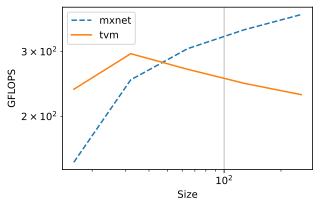

In [10]:
tvm_gflops = bench_conv_tvm(cached_block, sizes, target)
utils.plot_gflops(channels, [mxnet_gflops, tvm_gflops], ['mxnet', 'tvm'])